# ETA interpolation 

In [1]:
#add the aare build folder to sys.path to make it visible to python
import sys; sys.path.append('/home/l_msdetect/erik/aare/build')
from helpers import nb_aare_version
nb_aare_version()

import pickle

#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import boost_histogram as bh
import time

import tifffile

#Directly import what we need from aare
from aare import File, ClusterFile
from aare._aare import calculate_eta2, Interpolator
import aare

# old data with frame number for each cluster, need custom reader
# base = Path('/mnt/sls_det_storage/moench_data/tomcat_nanoscope_21042020/09_Moench_650um/')
# cluster_fname = base/'acq_interp_center_3.8Mfr_200V.clust'
# flatfield_fname = base/'flatfield_center_200_d0_f000000000000_0.clust'

#TOMO of eye
# base = Path('/mnt/sls_det_storage/moench_data/TriestePEPI_202502/pepi_data/CT_eye')
# cluster_fname = base/'BT_0.clust'
# ff_fname = base/'BT_4000.clust'

#bee
base = Path('/mnt/sls_det_storage/moench_data/TriestePEPI_202502/pepi_data/Tuesday_PhD/imaging')
ff_fname = base/'Bees_head_flat_10.clust'
cluster_fname= base/'Bees_head_10.clust'
eta_fname = "/home/l_msdetect/erik/tmp/eta_hist_bee.pkl"
ff_hist_fname = "/home/l_msdetect/erik/tmp/ff_hist_bee.pkl"
ff_hitmap_hist_fname = "/home/l_msdetect/erik/tmp/ff_hitmap_hist_bee.pkl"
img_hist_fname = "/home/l_msdetect/erik/tmp/img_hist_bee.pkl"
img_hitmap_hist_fname = "/home/l_msdetect/erik/tmp/img_hitmap_hist_bee.pkl"

Example run on: **2025-03-18 17:37** with aare: **dev**

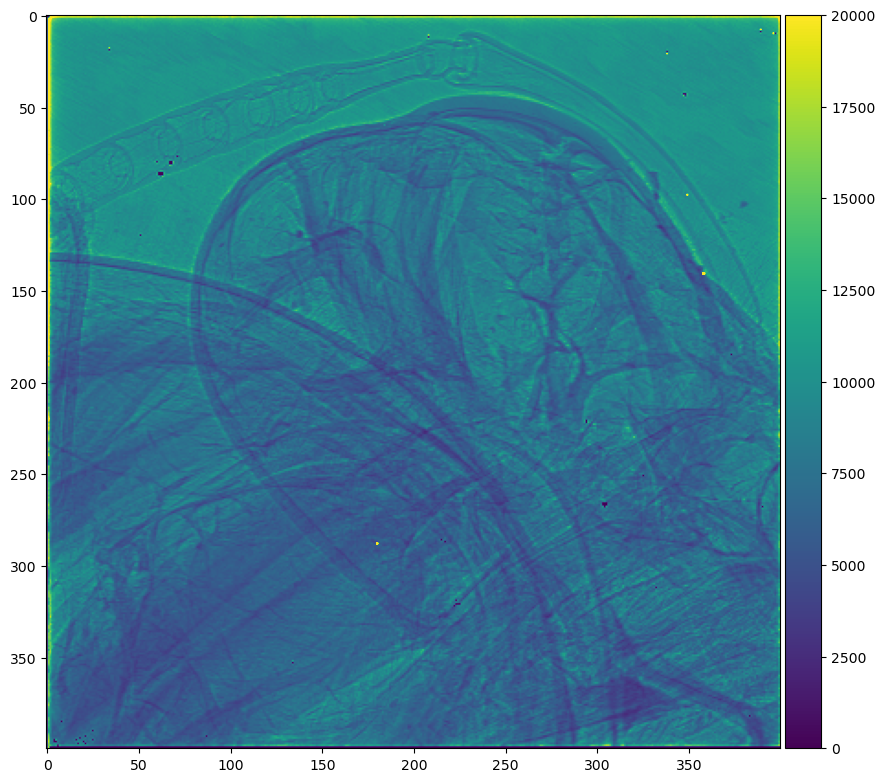

In [2]:
img = tifffile.imread(cluster_fname.with_suffix('.tiff'))
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(img)
im.set_clim(0,2e4)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

## Fill a 3D histogram with the ETA values

- when using eta3 ...
- For polychromatic images make a 3D histogram with x,y, energy 

In [3]:
make_eta = False
save_eta = False

#configure histogram
n_bins = 400
ax_min = -0.2
ax_max = 1.2

chunk_size = 10_000_000
n_chunks = 10


forecase_chunks = ff_fname.stat().st_size/40/chunk_size
print(f'File has up to: {forecase_chunks:.0f} chunks')

e_min = 500  
e_max = 8000
e_bins = 35

#adaptive energy bins
# energy_axis = np.array((1000, 1200, 1400, 1600, 1800, 2400, 3000, 4000, 6000, 8000))
gain = 155
print(f'{e_min/gain:.1f}-{e_max/gain:.1f}')

hist = bh.Histogram(
    bh.axis.Regular(n_bins, ax_min, ax_max), 
    bh.axis.Regular(n_bins, ax_min, ax_max),
    bh.axis.Regular(e_bins, e_min, e_max),
#     bh.axis.Variable(energy_axis)
)
roi = aare.ROI(xmin = 10, xmax = 390, ymin = 10, ymax = 390)

ebins = np.array(hist.axes.edges.T[2].flat)
print(ebins/gain)


first = False
if make_eta:
    t0 = time.perf_counter()
    with ClusterFile(ff_fname) as f:
        for i in range(n_chunks):
            clusters = f.read_clusters(chunk_size, roi)
#             clusters = f.read_clusters(chunk_size)
            if clusters.size == 0:
                print(f'EOF reached')
                break
            #TODO!Fuse these calculations in C++
#             eta2 = calculate_eta2(clusters)
#             energy = clusters.sum_2x2()
#             hist.fill(eta2[:,0], eta2[:,1], energy, threads = 8)

            if first:
                first = False
                hist2 = bh.Histogram(
                    bh.axis.Regular(100, 0, 8000)
                )
                hist2.fill(clusters.sum_2x2())
                m = hist2.values().max()
                fig, ax = plt.subplots()
                ax.step(hist2.axes[0].edges[:-1], hist2.values(), where="post");
                ax.set_xticks(hist.axes[2].edges)
                ax.grid()
                ax.set_yscale('log')
            print(f'chunk: {i}/{n_chunks}', end = '\r')
    print()

    t_elapsed = time.perf_counter()-t0
    print(f'Processing eta took: {t_elapsed:.3f}s')
    if save_eta:
        with open(eta_fname, "wb") as f:
            pickle.dump(hist, f)
else:
    #No reprocessing of the eta, just load the histogram
    with open(eta_fname, "rb") as f:
        hist = pickle.load(f)

File has up to: 494 chunks
3.2-51.6
[ 3.22580645  4.60829493  5.99078341  7.37327189  8.75576037 10.13824885
 11.52073733 12.90322581 14.28571429 15.66820276 17.05069124 18.43317972
 19.8156682  21.19815668 22.58064516 23.96313364 25.34562212 26.7281106
 28.11059908 29.49308756 30.87557604 32.25806452 33.640553   35.02304147
 36.40552995 37.78801843 39.17050691 40.55299539 41.93548387 43.31797235
 44.70046083 46.08294931 47.46543779 48.84792627 50.23041475 51.61290323]


Text(0.5, 1.0, 'ETA')

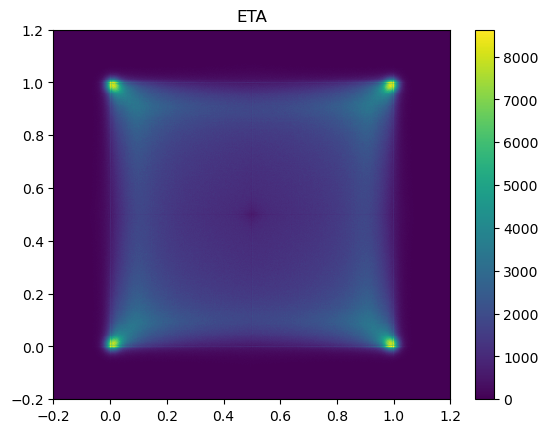

In [4]:
data = hist.view()[:,:,2]
# print(f'{data.shape=}')
x = hist.axes.edges.T[0].flat
# print(f'{x.shape=}')
y = hist.axes.edges.T[1].flat
# print(f'{y.shape=}')
fig, ax = plt.subplots()
mesh = ax.pcolormesh(x,y,data)
fig.colorbar(mesh)
# mesh.set_clim(0,.8e5)
ax.set_title('ETA')
# print(hist.axes.edges.T[2])

## Prepare the data for interpolation

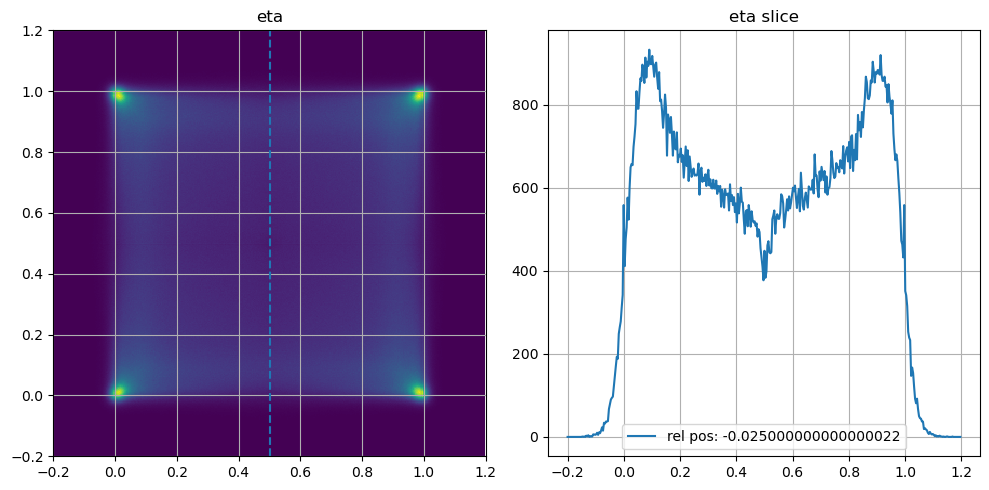

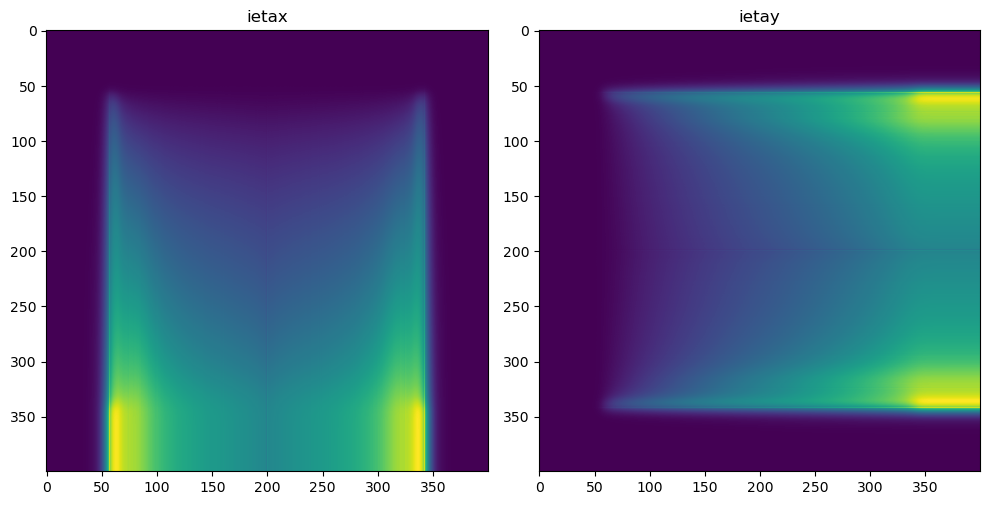

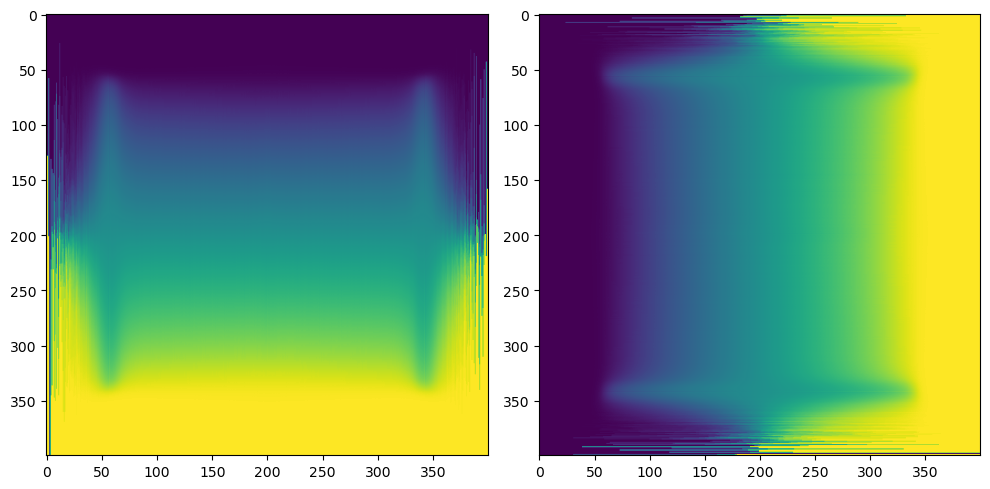

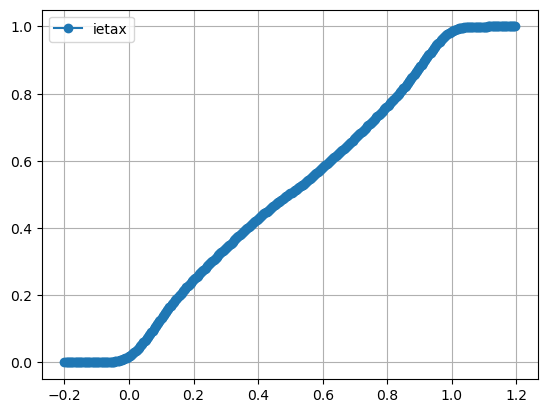

In [5]:
vis_index = 3
x_index = 200


plot_prep = True
eta = hist.view().copy()
etabinsx = np.array(hist.axes.edges.T[0].flat)
etabinsy = np.array(hist.axes.edges.T[1].flat)
ebins = np.array(hist.axes.edges.T[2].flat)

x_pos = etabinsx[x_index]

if plot_prep:
    fig, axs = plt.subplots(1,2, figsize = (10,5))
    axs[0].pcolormesh(etabinsx[:-1], etabinsy[:-1], eta[:,:,vis_index])
    axs[0].set_xlim(-0.2,1.2)
    axs[0].set_ylim(-0.2,1.2)
    axs[0].set_title('eta')
    axs[0].plot([x_pos,x_pos], [-0.2,1.2], '--')
    axs[1].plot(etabinsx[:-1], eta[:,x_index, vis_index], label = f'rel pos: {etabinsx[50]}')
    axs[1].set_title('eta slice')
    axs[1].legend()
    for ax in axs:
        ax.grid()
    fig.tight_layout()

ietax=np.cumsum(eta,axis=0)
ietay=np.cumsum(eta,axis=1)

if plot_prep:
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(ietax[:,:,vis_index])
    axs[1].imshow(ietay[:,:,vis_index])
    axs[0].set_title('ietax')
    axs[1].set_title('ietay')
    fig.tight_layout()

netax=np.transpose(np.tile(ietax[-1,:,:],ietax.shape[0]).reshape(ietax.shape),[1,0,2])
netax[np.where(netax<1)]=1
ietax=ietax/netax
etabinsy = np.array(hist.axes.edges.T[1].flat)
ietay=np.cumsum(eta,axis=1)
netay=np.tile(ietay[:,-1,:],ietay.shape[1]).reshape(ietay.shape)
netay[np.where(netay<1)]=1
ietay=ietay/netay
if plot_prep:
    fig, axs = plt.subplots(1,2, figsize = (10,5))
    axs[0].imshow(ietax[:,:,vis_index])
    axs[1].imshow(ietay[:,:,vis_index])
    fig.tight_layout()

    fig, ax = plt.subplots()
    ax.plot(etabinsx[:-1], ietax[:, x_index, vis_index], 'o-',label = f'ietax')
    ax.grid()
    ax.legend()



ebins = np.array(hist.axes.edges.T[2].flat)


## Flatfield

In [6]:
n_bins = 2000
xmin = 0
xmax = 400
scale = n_bins**2/400**2

make_flatfield = False
chunk_size = 1_000_000
forecase_chunks = ff_fname.stat().st_size/40/chunk_size
print(f'File has up to: {forecase_chunks:.0f} chunks')

if make_flatfield:
    t0 = time.perf_counter()
    hist = bh.Histogram(
        bh.axis.Regular(n_bins, xmin, xmax), 
        bh.axis.Regular(n_bins, xmin, xmax),
        bh.axis.Regular(e_bins, e_min, e_max)
    )
    
    hit_hist = bh.Histogram(
        bh.axis.Regular(400, 0-.5, 400-.5), 
        bh.axis.Regular(400, 0-.5, 400-.5),
        bh.axis.Regular(e_bins, e_min, e_max)
    )


    hm = np.zeros((400,400))
    p = Interpolator(eta, etabinsx[:-1], etabinsy[:-1], ebins[:-1]) 
    i = 0
    with ClusterFile(ff_fname, chunk_size = chunk_size) as f:
        for clusters in f:
            photons = p.interpolate(clusters)
            arr = np.array(clusters, copy=False)
            hist.fill(photons['y'], photons['x'], photons['energy'])
            hit_hist.fill(arr['y'], arr['x'], clusters.sum_2x2())
            i+=1
            if i==n_chunks:
                break
            print(f'chunk: {i}/{n_chunks}', end = '\r')
    with open(ff_hist_fname, "wb") as f:
        pickle.dump(hist, f)   
    with open(ff_hitmap_hist_fname, "wb") as f:
        pickle.dump(hit_hist, f) 
    t_elapsed = time.perf_counter()-t0
    print(f'Processed flatfiled in {t_elapsed:.3f}s')
else:
    with open(ff_hist_fname, "rb") as f:
        hist = pickle.load(f)
    with open(ff_hitmap_hist_fname, "rb") as f:
        hit_hist = pickle.load(f)




File has up to: 4940 chunks


Text(0.5, 1.0, 'flatfield[:, : 3]')

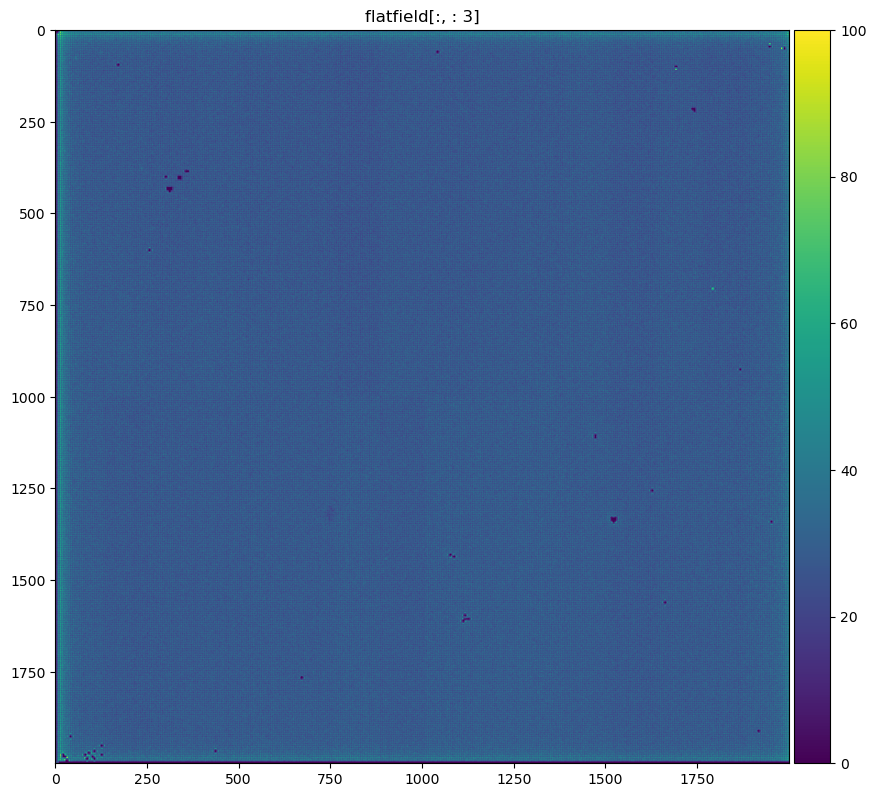

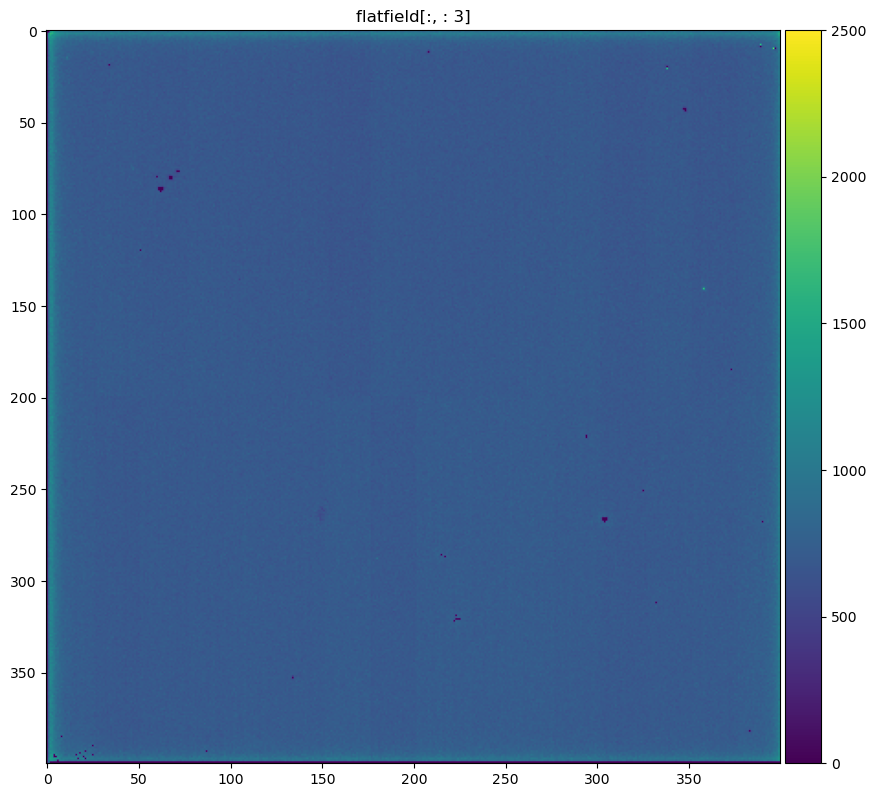

In [7]:
ff_hitmap = hit_hist.view().copy()
flatfield = hist.view().copy()
clim = np.array((0,100))
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(flatfield[:,:,vis_index])

im.set_clim(clim)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title(f'flatfield[:, : {vis_index}]')

fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(ff_hitmap[:,:,vis_index])

im.set_clim(clim*scale)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title(f'flatfield[:, : {vis_index}]')

In [8]:
make_image = False
chunk_size = 1_000_000
forecase_chunks = cluster_fname.stat().st_size/40/chunk_size
print(f'File has up to: {forecase_chunks:.0f} chunks')


if make_image:
    t0 = time.perf_counter()
    hist = bh.Histogram(
        bh.axis.Regular(n_bins, xmin, xmax), 
        bh.axis.Regular(n_bins, xmin, xmax),
        bh.axis.Regular(e_bins, e_min, e_max)
    )


    hit_hist = bh.Histogram(
        bh.axis.Regular(400, 0-.5, 400-.5), 
        bh.axis.Regular(400, 0-.5, 400-.5),
        bh.axis.Regular(e_bins, e_min, e_max)
    )
    i = 0
    with ClusterFile(cluster_fname, chunk_size = chunk_size ) as f:
        for clusters in f:
            photons = p.interpolate(clusters)
            arr = np.array(clusters, copy=False)
            hit_hist.fill(arr['y'], arr['x'], clusters.sum_2x2())
            hist.fill(photons['y'], photons['x'], photons['energy'])
            i+=1
            if i==n_chunks:
                break
            print(f'chunk: {i}/{n_chunks}', end = '\r')

    
    with open(img_hist_fname, "wb") as f:
        pickle.dump(hist, f)
    with open(img_hitmap_hist_fname, "wb") as f:
        pickle.dump(hit_hist, f)
        
    t_elapsed = time.perf_counter()-t0
    print(f'Processing image: {t_elapsed:.3f}s')
else:
    with open(img_hist_fname, "rb") as f:
        hist = pickle.load(f)
    with open(img_hitmap_hist_fname, "rb") as f:
        hit_hist = pickle.load(f)
        
image = hist.view().copy()
hitmap = hit_hist.view().copy()

File has up to: 1241 chunks


Text(0.5, 1.0, 'hitmap[:,:,3]')

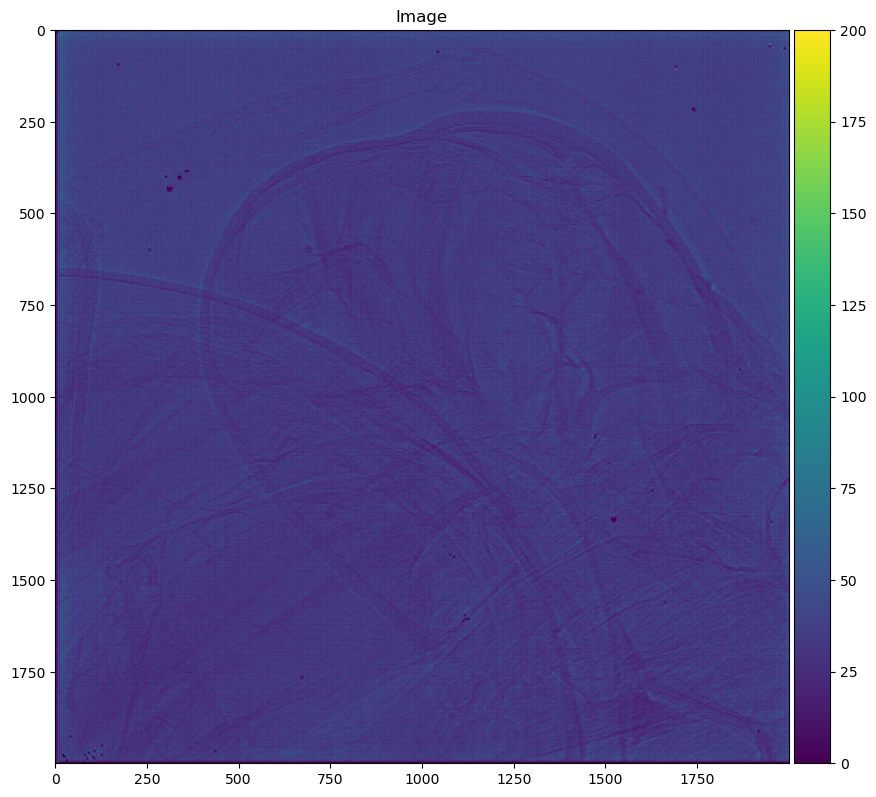

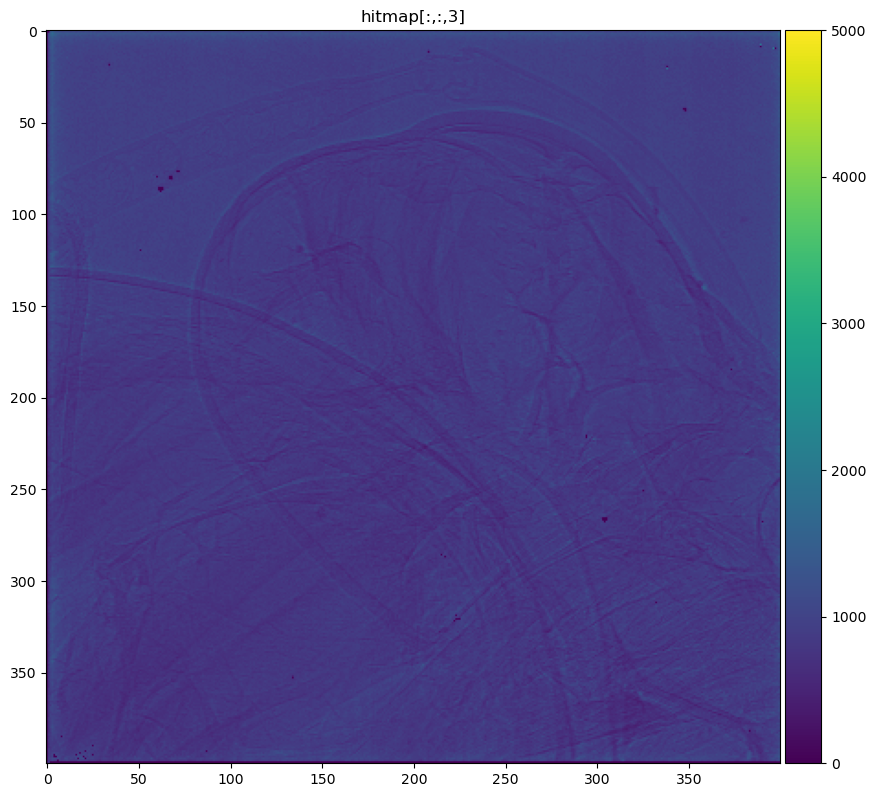

In [9]:
clim = np.array((0,200))
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(image[:,:,vis_index])
im.set_clim(clim)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('Image')

fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(hitmap[:,:,vis_index])
im.set_clim(clim*scale)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title(f'hitmap[:,:,{vis_index}]')

In [10]:
#do proper flatfield correction
#1/(a/a.mean())
# for e in hist.axes[2]:
#     print(e)
# print(hist.view().shape)
# image = hist.view()[:,:,2:3].sum(axis = 2)

ff = np.zeros(flatfield.shape)
for i in range(flatfield.shape[2]):
    ff[:,:,i] = flatfield[:,:,i]/flatfield[:,:,i].mean()

# ff= flatfield/flatfield.mean()
ff[ff==0] = 1
ff = 1/ff
interpolated = image*ff
print(interpolated.shape)

(2000, 2000, 10)


Text(0.5, 1.0, 'Hitmap')

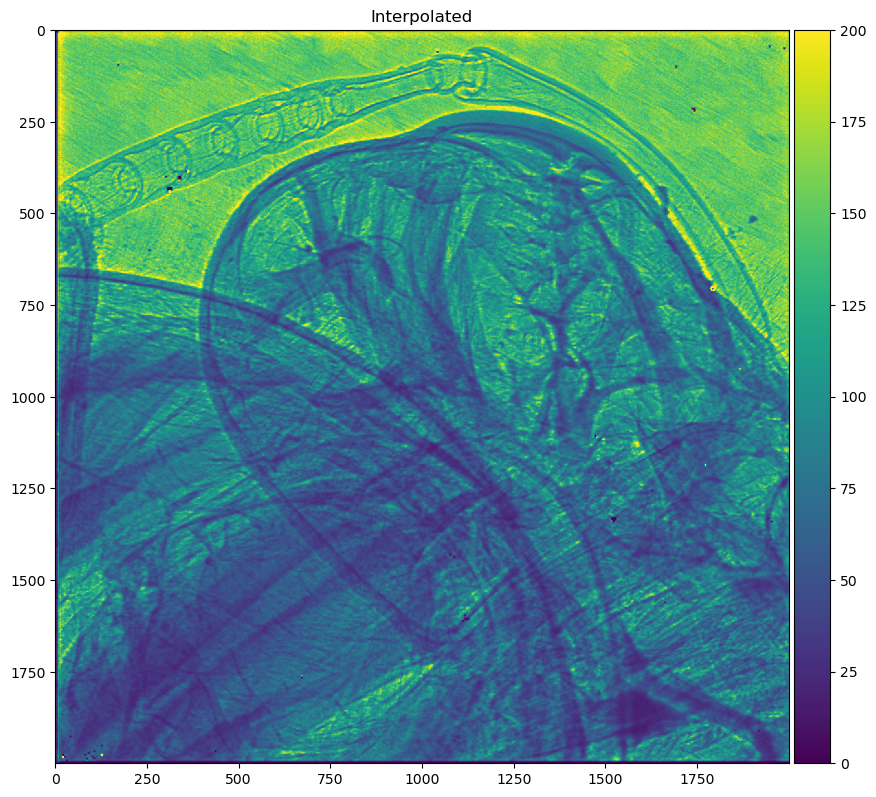

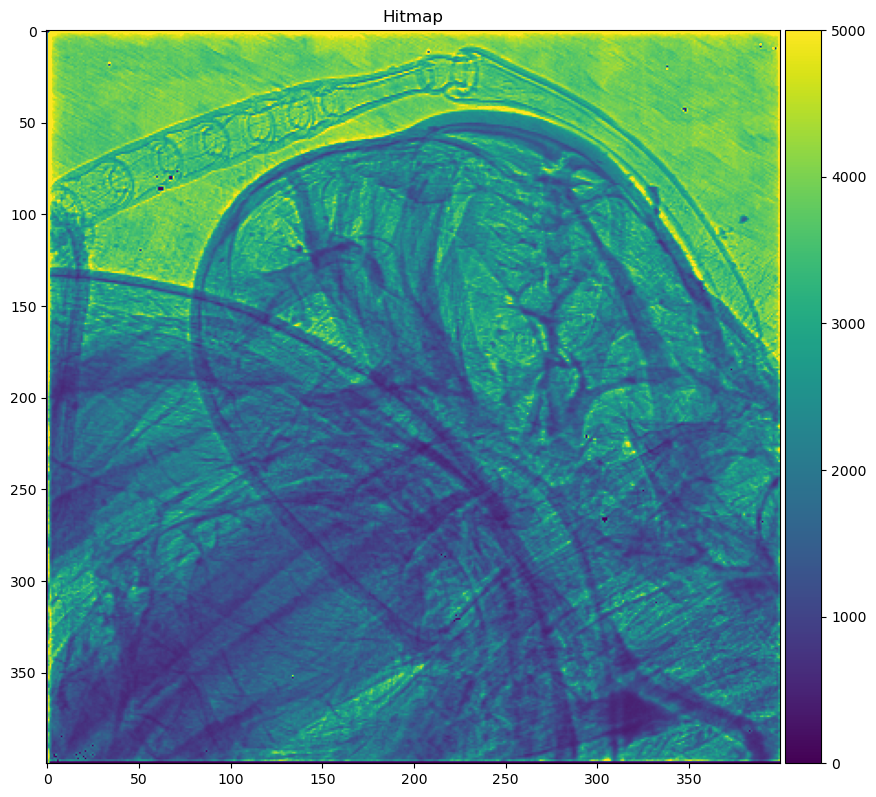

In [16]:
vis_index = 0
clim = np.array((0,200))
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(interpolated[:,:,vis_index])
im.set_clim(clim)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('Interpolated')

fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(hitmap[:,:,vis_index])
im.set_clim(clim*scale)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('Hitmap')

In [12]:
n_bins = 2000

Text(0.5, 1.0, 'Hitmap')

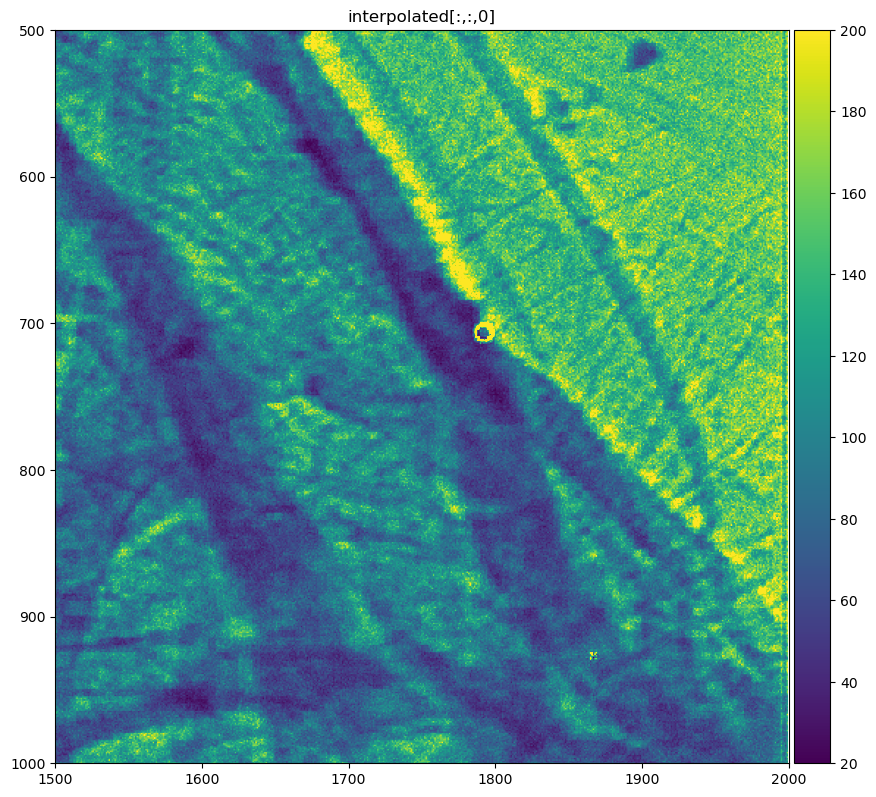

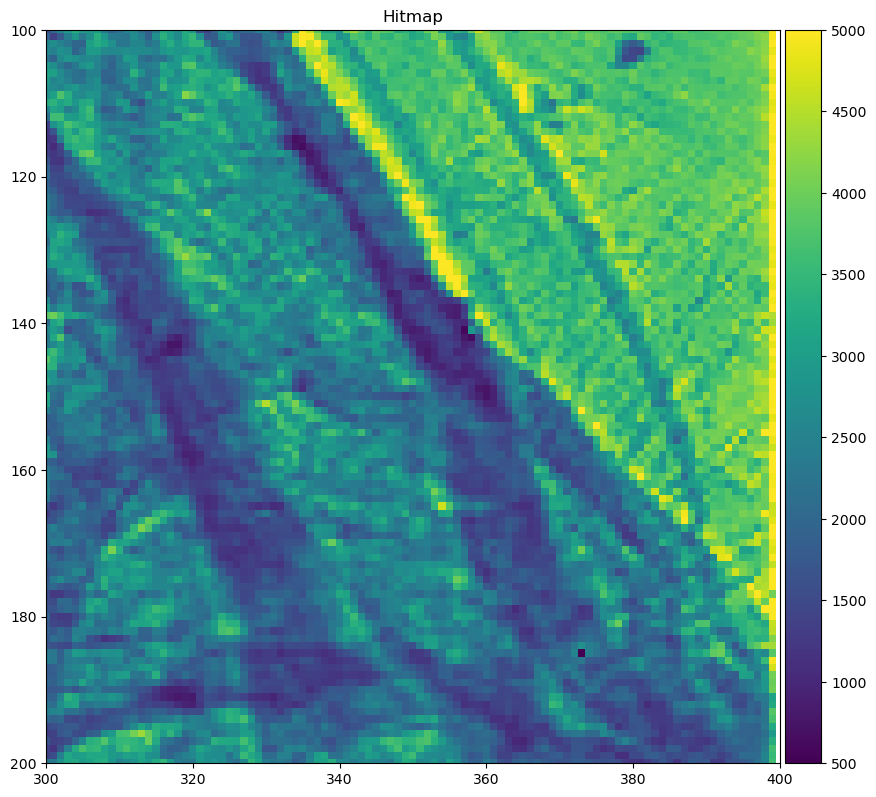

In [18]:
xlim = np.array((300,400))
ylim = np.array((200,100))
clim = np.array((20,200))
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(interpolated[:,:,vis_index])
im.set_clim(clim)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title(f'interpolated[:,:,{vis_index}]')
ax.set_xlim(xlim*n_bins/400)
ax.set_ylim(ylim*n_bins/400)


fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(hitmap[:,:,vis_index])
im.set_clim(clim*scale)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('Hitmap')

NameError: name 'p' is not defined

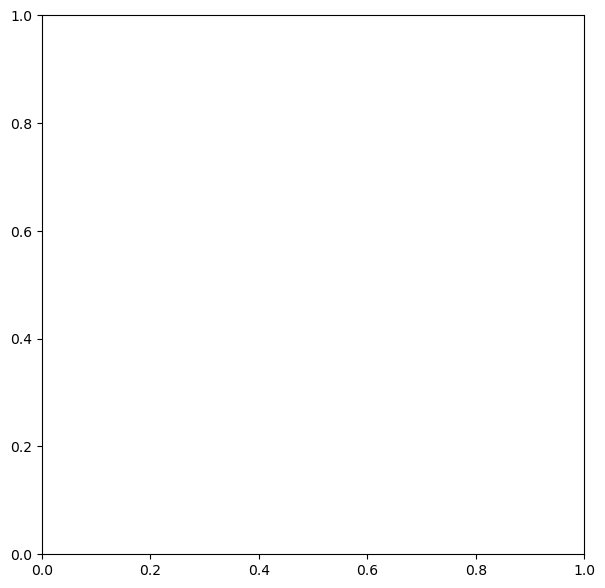

In [14]:
n_clusters = 1000
image = np.zeros((401,401))
with ClusterFile(cluster_fname) as f:
    clusters = f.read_clusters(n_clusters)

fig,ax = plt.subplots(figsize = (7,7))   
arr = np.array(clusters, copy = False)
photons = p.interpolate(clusters)

#select one cluster: 
i = np.random.randint(n_clusters)
print(f'selected: {i}')

# for i,c in enumerate(arr):
c = arr[i]
x = c['x']
y = c['y']
data = c['data']
if 1<x<399 and 1<y<399:
#         print(f'x:{x}, y:{y}')
    for dx in [-1,0,1]:
        for dy in [-1,0,1]:
            image[y+dy, x+dx] += c['data'][1+dx,1+dy]
    ax.plot(photons[i]['x'], photons[i]['y'], marker = 'x', markersize = 5,color = 'red')
#         ax.plot(x,y, marker = 'x', markersize = 3,color = 'red')
        

    

# im = ax.imshow(image, extent = [0,400, 400, 0])
im = ax.pcolormesh(image)
xlim = (x-3, x+3)
ylim = (y-3, y+3)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

im.set_clim(-100,1000)
ax.grid()



# n_bins = 1600
# xmin = 0
# xmax = 400
# e_min = 1000
# e_max = 8000
# e_bins = 5
# hist = bh.Histogram(
#     bh.axis.Regular(n_bins, xmin, xmax), 
#     bh.axis.Regular(n_bins, xmin, xmax),
#     bh.axis.Regular(e_bins, e_min, e_max)
# )

# hist.fill(photons['y'], photons['x'], photons['energy'])
# image_int = hist.view().sum(axis = 2)

# fig,ax = plt.subplots(figsize = (12,12))  
# im = ax.imshow(image_int, extent = [0,400,0,400])
# # im = ax.imshow(image_int, )
# im.set_clim(0,1)
# # ax.set_xlim(xlim)
# # # ax.set_
# # ax.set_ylim(ylim)
# print(image_int.sum())


In [ ]:
eta2 = calculate_eta2(clusters)
for ((x,y,tot), (ex, ey)) in zip(arr,eta2):
    ibx=(np.abs(etabinsx - ex)).argmin() #Find out which bin the eta should land in 
    iby=(np.abs(etabinsy - ey)).argmin()
    ie = (np.abs(be - ey)).argmin()
    px=ietax[ibx,iby] #Lookup in the histogram using bins
    py=ietay[ibx,iby]
    print(x,y,px[ie], py[ie])

In [ ]:
ebins/150